<a href="https://colab.research.google.com/github/alvarolj23/brujulaDataScientist/blob/main/02_EDA_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# System preparation

## Import libraries

In [1]:
#pip install scikit-plot

You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
# Data 
import numpy as np
import pandas as pd

#Regular expressions
import re as re

# Utilities
from time import time


# Others
import warnings
from functools import reduce
from pathlib import Path
import os


In [5]:
# Configurations.
%matplotlib inline
sns.set_style("darkgrid")
warnings.filterwarnings("ignore")
plt.rc("font", family="serif", size=15)

# 1. EXPLORATORY DATA ANALYSIS

For this first deliverable, it won't be possible getting any data from the client. Shall a vast know-how and expertise needs to be demostrated before the compressor company is willing to share internal data. 

For this reason, the scope of the project will be reduced in the first instance to a dataset gathered from Kaggle.



## Read the data

**The data downloaded from Kaggle was artificially generated**

---------------------------

**Compressor condition monitoring and health status**
- Sensors data: conditions of the compressors given by the data collected in the different sensors. 
- Failure History: The failure history of the compressors. It's indicated by the failure in the different components of the compressors. Failure means the component stop working and was replaced in a specific date.


----------------
**Other collected data**
- Error codes: Error history of the compressor. The errors are given by the PLC of the compressor. They were programmed based on treshold values, abnormal behaviour, shutdowns, etc.
- Maintenance History: The repair history of the compressors. It's indicated by the maintenance in the different components of the compressors. Maintenance means a component was maintained due to:
  - Scheduled maintenance
  - Regular inspections
  - Error code given by the compressor
  - Failure in one component
- Compressors characteristics: The characteristics of the compressors, model and age.

In [8]:
# Load csv data with pandas
sensors = pd.read_csv("../data/compressors_sensor_data.csv", error_bad_lines=False)
failures = pd.read_csv("../data/compressors_failures.csv", error_bad_lines=False)

errors = pd.read_csv("../data/compressors_errors.csv", error_bad_lines=False)
maintenance = pd.read_csv("../data/compressors_maintenance.csv", error_bad_lines=False)
compressor_info = pd.read_csv("../data/compressors_machines_info.csv", error_bad_lines=False)

b'Skipping line 92490: expected 6 fields, saw 9\n'


## Data limitations

Since the telemetry data coming from the sensors is only effective from 1 year time, the number of failures that we will find corresponds only to this period.

The dataset will be very imbalanced. Failures will be produced in a very small ratio compared with healthy compressor data.

## Data visualization

### Sensors

The intention of selecting the data from Kaggle, is that it follows a similar pattern as the sample received from AC. In terms of level, trend, noise and seasonality, the data offered by this artificially generated dataset found in Kaggle, meets the same components than AC sample.

We will plot the sensor data to prove that is similar to the one collected from AC. The plot will show only data for one compressor in a small period, to be able to identify the pattern.

In [9]:
# Columns of sensors dataframe
sensors.columns=['datetime' , 'compressorID' , 'current' , 'rpm' , 'pressure' , 'vibration']

In [10]:
# Change the formate of the datetime
sensors["datetime"] = pd.to_datetime(sensors["datetime"], format="%Y-%m-%d %H:%M:%S")

In [11]:
# Select the compressor
machine_ID = 1

# We establish the times corresponding to the records that will be used for ploting the data
initial_date = pd.to_datetime("2015-01-01 05:00:00")
final_date = pd.to_datetime("2015-01-15 05:00:00")

In [12]:
# Period to be plotted
plt_sensors = sensors[(sensors['compressorID'] == machine_ID) &
                      (sensors['datetime'] > initial_date) &
                      (sensors['datetime'] < final_date)]

In [13]:
plt_sensors.head()

,datetime,compressorID,current,rpm,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


Text(0, 0.5, 'mAmperes')

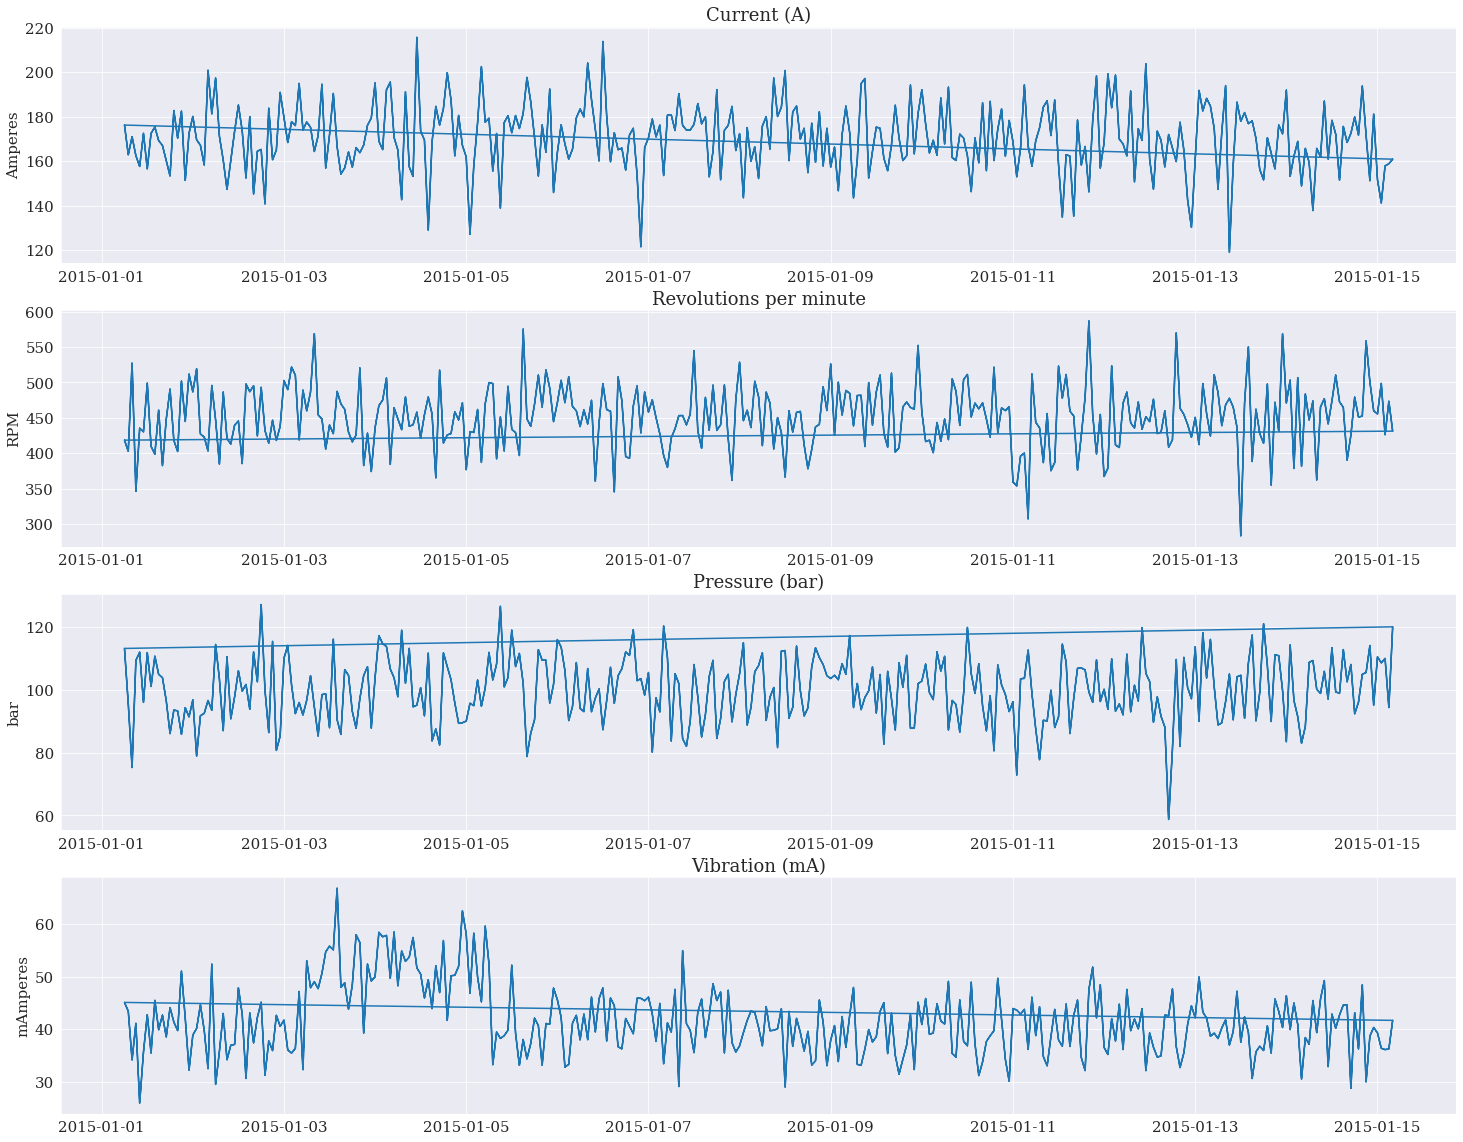

In [14]:
# Plot the different variables for an individual compressor in a reduced period

figure, axes = plt.subplots(4,1,figsize=(25,20))
axes[0].plot(plt_sensors['datetime'] , plt_sensors['current'])
axes[1].plot(plt_sensors['datetime'] , plt_sensors['rpm'])
axes[2].plot(plt_sensors['datetime'] , plt_sensors['pressure'])
axes[3].plot(plt_sensors['datetime'] , plt_sensors['vibration'])

axes[0].title.set_text('Current (A)')
axes[1].title.set_text('Revolutions per minute')
axes[2].title.set_text('Pressure (bar)')
axes[3].title.set_text('Vibration (mA)')

axes[0].set_ylabel('Amperes')
axes[1].set_ylabel('RPM')
axes[2].set_ylabel('bar')
axes[3].set_ylabel('mAmperes')

The data plotted above, follows the same level, seasonality and trend to the data received from AC. Hence, we will use it for the first delivery of this project.

In the kaggle dataset, we have time series data for the telemetry sensors: current, rotation, pressure and vibration measurements collected from 100 compressors in real time averaged over each hour collected during the year 2015.

In [15]:
sensors.head()

,datetime,compressorID,current,rpm,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


**To understand sensor data** 

Sensor data can be seen as time series.
*Time Series is a set of data points or observations taken at specified times usually at equal intervals (e.g hourly, daily, weekly, quarterly, yearly, etc).* 

In our compressors, data is collected using an interval of 1 hour.


Time Series is usually used to predict future occurrences based on previous observed occurrence or values. 


Sensor data can be decomposed in 4 different components.

y(t) = Level(t) + Trend(t) + Seasonality(t) + Noise(t)


1. Level: The average value in the series.
2. Trend: The increasing or decreasing value in the series.
3. Seasonality: The repeating short-term cycle in the series.
4. Noise: The random variation in the series.


In [16]:
sensors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968588 entries, 0 to 968587
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   datetime      968588 non-null  datetime64[ns]
 1   compressorID  968588 non-null  int64         
 2   current       968588 non-null  float64       
 3   rpm           968588 non-null  float64       
 4   pressure      968588 non-null  float64       
 5   vibration     968588 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 44.3 MB


Total number of compressors that are collected in this dataset.

In [17]:
# Total number of compressors
sensors['compressorID'].nunique()

100

Total number of datapoints collected in 2015

In [18]:
# Rows of the dataset, number o datapoints collected
sensors = sensors.drop_duplicates()
len(sensors)

876100

Characteristics for the sensor values: mean, std, min, max, ...

In [19]:
# We use the describe method to see information such as: mean, std...
sensors.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
compressorID,876100.0,50.500000,28.866087,1.000000,25.750000,50.500000,75.250000,100.000000
current,876100.0,170.777736,15.509114,97.333604,160.304927,170.607338,181.004493,255.124717
rpm,876100.0,446.605119,52.673886,138.432075,412.305714,447.558150,482.176600,695.020984
pressure,876100.0,100.858668,11.048679,51.237106,93.498181,100.425559,107.555231,185.951998
vibration,876100.0,40.385007,5.370361,14.877054,36.777299,40.237247,43.784938,76.791072


**Normality test of the sensor data**

It will be studied if the data collected by the sensors follows a normal distribution. Hence, Kernel Density Estimation will be used 

A normal distribution indicates a natural behaviour is followed in a representative sample (Central Limit Theorem)

In case only one group is shown, we can make the assumption that all the compressors have similar behaviour independently of the model. Otherwise, there would be different clusters wich behave differently ones from the others.

**Parametric models** expect normal distributions because they use the mean, std, and other arithmetic values.

**Non-parametric models** e.g. CART (Classification and Regression Trees), are insensitive to the distribution of data, all that matters is creating nodes that maximize class separation. 


<AxesSubplot:xlabel='vibration', ylabel='Density'>

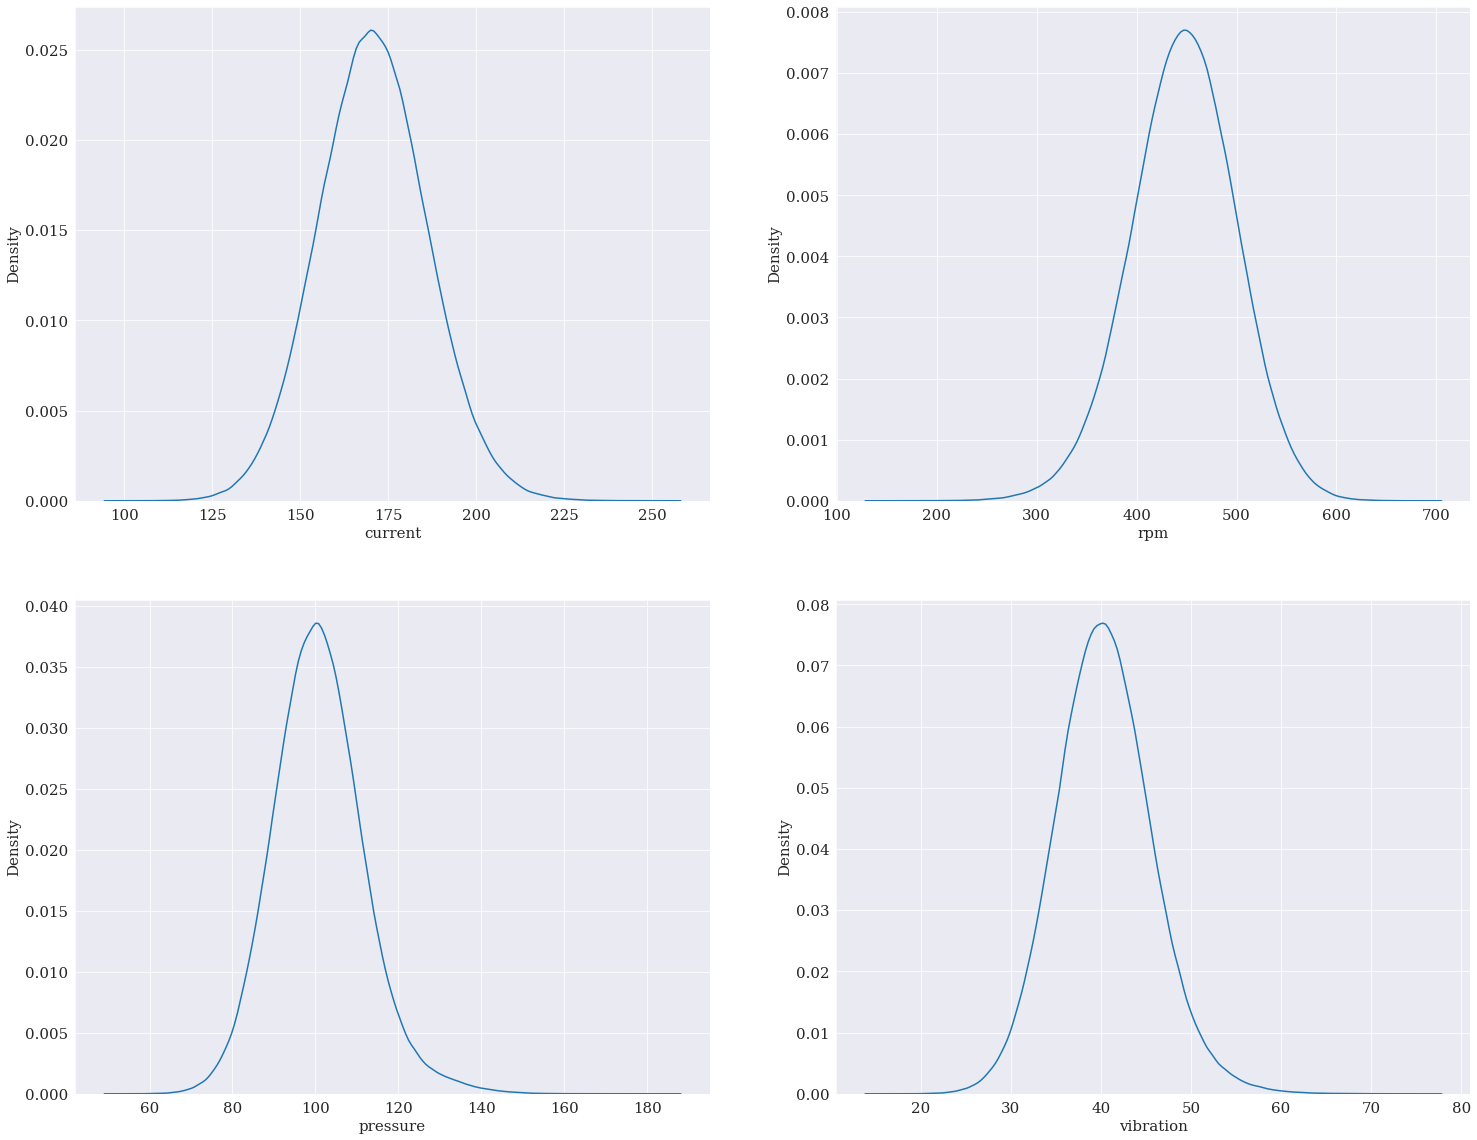

In [20]:
#Kernel Density Estimation plot
figure, axes = plt.subplots(2,2,figsize=(25,20))
sns.kdeplot(sensors['current'], ax = axes[0,0])
sns.kdeplot(sensors['rpm'], ax = axes[0,1])
sns.kdeplot(sensors['pressure'], ax = axes[1,0])
sns.kdeplot(sensors['vibration'], ax = axes[1,1])


### Failures of components

These are the records of *component replacements due to failures*. Each record has a date and time, machine ID, and the failed component. 

We assume followed by a catastrophic failure, there is always a maintenance in the component associated. Therefore, associated to a failure, there will always be a maintenance in the component which broke down or is no longer usable.

In [21]:
#Define names of the columns
failures.columns=['datetime' , 'compressorID' , 'failure_comp' ]

In [22]:
# Change the formate of the datetime
failures["datetime"] = pd.to_datetime(failures["datetime"], format="%Y-%m-%d %H:%M:%S")

# Define as categorical value
failures["failure_comp"] = failures["failure_comp"].astype("category")

In [23]:
failures.head()

,datetime,compressorID,failure_comp
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [24]:
# Dtypes of the failures dataframe
failures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      761 non-null    datetime64[ns]
 1   compressorID  761 non-null    int64         
 2   failure_comp  761 non-null    category      
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 13.0 KB


Counting the total number of failures

In [25]:
# Total number of failures
failures = failures.drop_duplicates()
len(failures)

761

<AxesSubplot:xlabel='failure_comp', ylabel='count'>

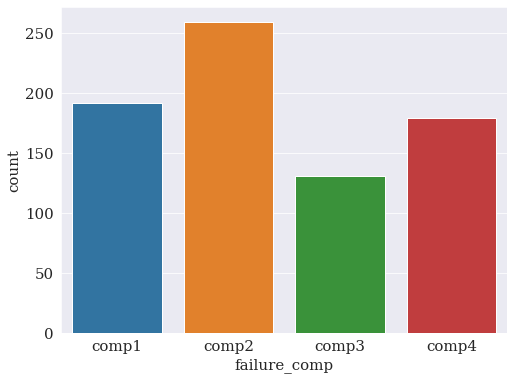

In [26]:
# Countplot with the number of failures for the different components
plt.figure(figsize=(8, 6))
sns.countplot(failures.failure_comp , order = ['comp1', 'comp2' , 'comp3' , 'comp4'])

### Errors

In this dataframe we find warning errors, generated by the compressor when it's still operating. They are not considered failures because they are not catastrophic.
Dates and hours are approached to the closest telemetry datetime, in order to not lose the homogeneity of 1 hour for the telemetry data.

In [27]:
errors.columns=['datetime' , 'compressorID' , 'errorID']

In [28]:
# Change the formate of the datetime
errors["datetime"] = pd.to_datetime(errors["datetime"], format="%Y-%m-%d %H:%M:%S")

# Define as categorical value
errors["errorID"] = errors["errorID"].astype("category")

In [29]:
errors.head()

,datetime,compressorID,errorID
0,2015-01-04 07:00:00,1,error1
1,2015-01-04 20:00:00,1,error3
2,2015-01-05 06:00:00,1,error5
3,2015-01-11 15:00:00,1,error4
4,2015-01-23 10:00:00,1,error4


In [30]:
# Dtypes and errors info
errors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      3919 non-null   datetime64[ns]
 1   compressorID  3919 non-null   int64         
 2   errorID       3919 non-null   category      
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 65.4 KB


In [31]:
# Total number of errors produced
errors = errors.drop_duplicates()
len(errors)

3919

<AxesSubplot:xlabel='errorID', ylabel='count'>

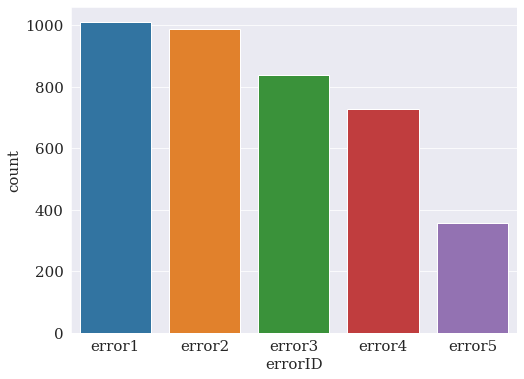

In [32]:
# Countplot of the different types of errors produced
plt.figure(figsize=(8, 6))
sns.countplot(errors.errorID , order = ['error1', 'error2' , 'error3' , 'error4' ,'error5'])

### Maintenance

These registers correspond to components which were replaced due to: 
- Scheduled maintenance
- Regular inspections
- Failures

Maintenance data starts in 2014 and has data for 2015.


In [33]:
#Define maintenance columns names
maintenance.columns=['datetime' , 'compressorID' , 'maint_comp']

In [34]:
# Change the formate of the datetime
maintenance["datetime"] = pd.to_datetime(maintenance["datetime"], format="%Y-%m-%d %H:%M:%S")

# Define as categorical value
maintenance["maint_comp"] = maintenance["maint_comp"].astype("category")

In [35]:
maintenance.head()

,datetime,compressorID,maint_comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [36]:
maintenance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      3286 non-null   datetime64[ns]
 1   compressorID  3286 non-null   int64         
 2   maint_comp    3286 non-null   category      
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 54.9 KB


In [37]:
# Drop duplicates and see total number of maintenance operations
maintenance = maintenance.drop_duplicates()
len(maintenance)

3286

<AxesSubplot:xlabel='maint_comp', ylabel='count'>

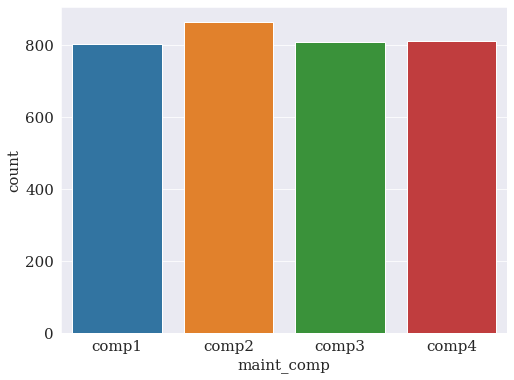

In [38]:
# Plot total number of maintenance operations by component
plt.figure(figsize=(8, 6))
sns.countplot(maintenance.maint_comp , order = ['comp1', 'comp2' , 'comp3' , 'comp4' ])

### Compressors information

This dataset has information of each compressor:
- Model of compressor
- Age or years of service

In [39]:
# Define name of the compressor info columns
compressor_info.columns=['compressorID' , 'model' , 'age' ]

In [40]:
compressor_info.head()

,compressorID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [41]:
compressor_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   compressorID  100 non-null    int64 
 1   model         100 non-null    object
 2   age           100 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.5+ KB


In [42]:
# Define as categorical value
compressor_info["model"] = compressor_info["model"].astype("category")

With the Kernel Density Estimation plot, we can see if there are different groups of compressors related to their ancienity. In this case we can say that only a clear group is observed

<AxesSubplot:xlabel='age', ylabel='Density'>

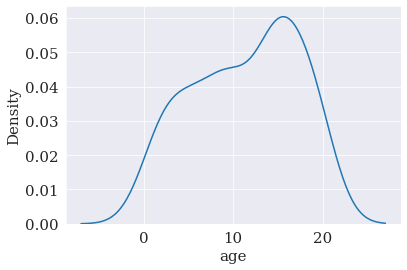

In [43]:
# We check if there are different groups of compressors 
sns.kdeplot(data= compressor_info, x = 'age' ) 

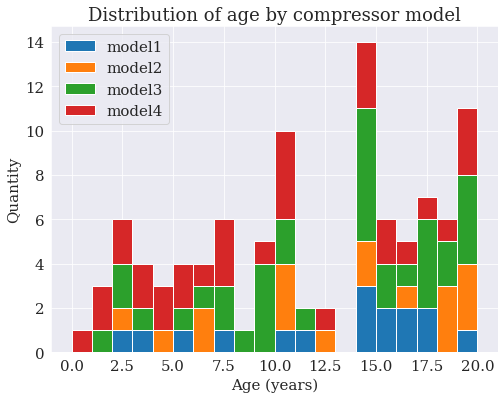

In [44]:
#Plot the average age of the compressors by model
plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist([
    compressor_info.loc[compressor_info["model"] == "model1", "age"],
    compressor_info.loc[compressor_info["model"] == "model2", "age"],
    compressor_info.loc[compressor_info["model"] == "model3", "age"],
    compressor_info.loc[compressor_info["model"] == "model4", "age"]],
    20, stacked=True, label=["model1", "model2", "model3", "model4"
])
plt.title("Distribution of age by compressor model")
plt.xlabel("Age (years)")
plt.ylabel("Quantity")
plt.legend()
plt.show()

## **Maintenance vs Failures vs Errors**

Number of ocurrences of maintenance vs failure

In [45]:
maintenance_merge = maintenance.copy()
maintenance_merge['origin'] = 'maintenance'
failures_merge = failures.copy()
failures_merge['origin'] = 'failures'

In [46]:
failures_maintenance = failures_merge.merge(maintenance_merge, how = 'outer', on = ['datetime', 'compressorID' , 'origin'])

In [47]:
failures_maintenance['comp'] = failures_maintenance['failure_comp'].combine_first(failures_maintenance['maint_comp'])

In [48]:
failures_maintenance.head()

,datetime,compressorID,failure_comp,origin,maint_comp,comp
0,2015-01-05 06:00:00,1,comp4,failures,NaN,comp4
1,2015-03-06 06:00:00,1,comp1,failures,NaN,comp1
2,2015-04-20 06:00:00,1,comp2,failures,NaN,comp2
3,2015-06-19 06:00:00,1,comp4,failures,NaN,comp4
4,2015-09-02 06:00:00,1,comp4,failures,NaN,comp4


<AxesSubplot:xlabel='comp', ylabel='count'>

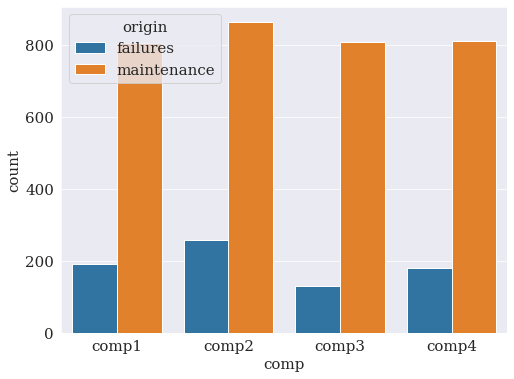

In [49]:
plt.figure(figsize=(8, 6))
sns.countplot(data= failures_maintenance, x= 'comp' , hue = 'origin')


Scatterplot in separated compressor: failures, maintenance, errors

In [50]:
# Select the compressor
compressor_number = 1

# We establish the times corresponding to the records that will be used for ploting the data
initial_date = pd.to_datetime("2015-01-01 06:00:00")
final_date = pd.to_datetime("2016-01-01 06:00:00")

In [51]:
errors_merge = errors.copy()
errors_merge['origin'] = 'errors'

In [52]:
fail_main_err= pd.DataFrame()

In [53]:
fail_main_err  = failures_merge.merge(maintenance_merge, how = 'outer', on = ['datetime', 'compressorID' , 'origin'])
fail_main_err  = fail_main_err.merge(errors_merge, how = 'outer', on = ['datetime', 'compressorID' , 'origin'])

In [54]:
cols = ['failure_comp', 'maint_comp', 'errorID']
fail_main_err["event"] = fail_main_err[cols].apply(lambda x: ','.join(x.dropna()), axis=1)

In [56]:
fail_main_err['event'] = fail_main_err['event'].apply(lambda row: re.findall(r'[0-9]+',row)[0])

In [57]:
fail_main_err_comp = fail_main_err[(fail_main_err['compressorID'] == compressor_number) &
                                   (fail_main_err['datetime'] > initial_date)&
                                   (fail_main_err['datetime'] < final_date)]

In [58]:
hue_events = fail_main_err_comp['event'].unique()

In [60]:
hue_events = list(hue_events)

In [61]:
hue_events.sort()

In [63]:
fail_main_err_comp.head()

,datetime,compressorID,failure_comp,origin,maint_comp,errorID,event
0,2015-01-05 06:00:00,1,comp4,failures,NaN,NaN,4
1,2015-03-06 06:00:00,1,comp1,failures,NaN,NaN,1
2,2015-04-20 06:00:00,1,comp2,failures,NaN,NaN,2
3,2015-06-19 06:00:00,1,comp4,failures,NaN,NaN,4
4,2015-09-02 06:00:00,1,comp4,failures,NaN,NaN,4


<AxesSubplot:xlabel='datetime', ylabel='event'>

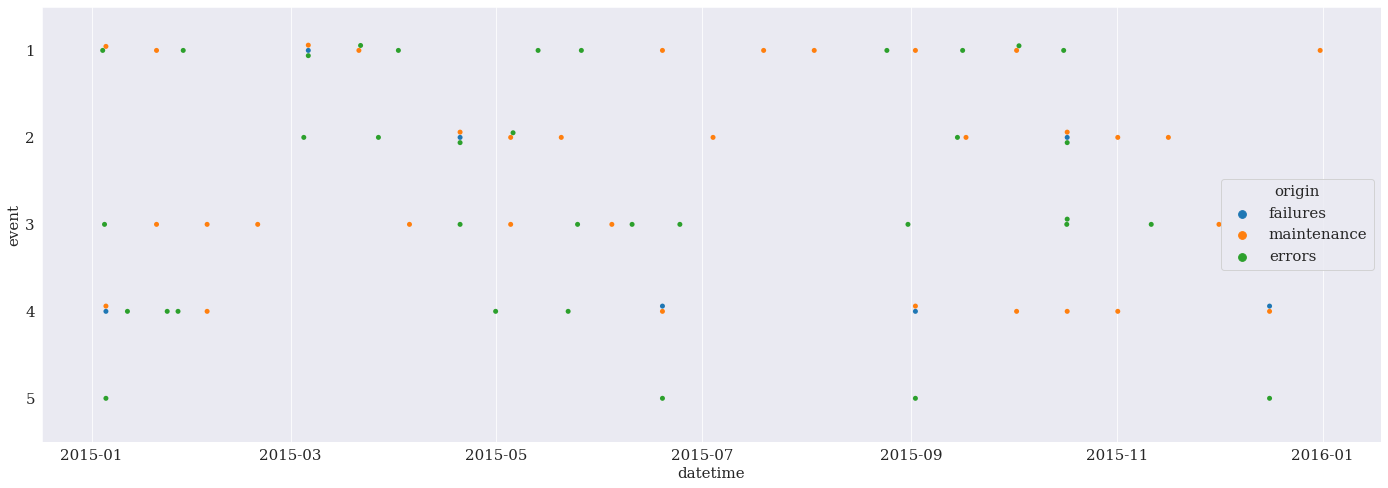

In [64]:
plt.figure(figsize=(24, 8))
sns.swarmplot(x="datetime", y="event", data=fail_main_err_comp, hue= 'origin', orient = "h", order=hue_events)

# Overview of the data

### Check if any empty value

In [65]:
sensors.isna().sum()

datetime        0
compressorID    0
current         0
rpm             0
pressure        0
vibration       0
dtype: int64

In [66]:
errors.isna().sum()

datetime        0
compressorID    0
errorID         0
dtype: int64

In [67]:
failures.isna().sum()

datetime        0
compressorID    0
failure_comp    0
dtype: int64

In [68]:
maintenance.isna().sum()

datetime        0
compressorID    0
maint_comp      0
dtype: int64

In [69]:
compressor_info.isna().sum()

compressorID    0
model           0
age             0
dtype: int64

## Merge dummies

### Create dummies

Errors

In [70]:
errors['errorID'].value_counts()

error1    1010
error2     988
error3     838
error4     727
error5     356
Name: errorID, dtype: int64

In [71]:
# Create dummies in order to collect all the info
errors_dum = pd.get_dummies(errors) # We put a 1 if the error appears for that machine, 0 otherwise.
errors_dum.columns = ["datetime", "compressorID", "error1", "error2", "error3", "error4", "error5"]

In [72]:
# Group by compressorID and datetime and reset the index
errors_dum = errors_dum.groupby(["compressorID", "datetime"]).sum().reset_index()

In [73]:
errors_dum.head()

,compressorID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-04 07:00:00,1,0,0,0,0
1,1,2015-01-04 20:00:00,0,0,1,0,0
2,1,2015-01-05 06:00:00,0,0,0,0,1
3,1,2015-01-11 15:00:00,0,0,0,1,0
4,1,2015-01-23 10:00:00,0,0,0,1,0


Maintenance

In [74]:
maintenance['maint_comp'].value_counts()

comp2    863
comp4    811
comp3    808
comp1    804
Name: maint_comp, dtype: int64

In [75]:
# Create dummies in order to collect all the info
maintenance_dum = pd.get_dummies(maintenance) 
maintenance_dum.columns = ["datetime", "compressorID", "comp1", "comp2", "comp3", "comp4"]

In [76]:
# Group by compressorID and datetime and reset the index
maintenance_dum = maintenance_dum.groupby(["compressorID", "datetime"]).sum().reset_index()

In [77]:
maintenance_dum.head()

,compressorID,datetime,comp1,comp2,comp3,comp4
0,1,2014-06-01 06:00:00,0,1,0,0
1,1,2014-07-16 06:00:00,0,0,0,1
2,1,2014-07-31 06:00:00,0,0,1,0
3,1,2014-12-13 06:00:00,1,0,0,0
4,1,2015-01-05 06:00:00,1,0,0,1


Failures

In [78]:
failures['failure_comp'].value_counts()

comp2    259
comp1    192
comp4    179
comp3    131
Name: failure_comp, dtype: int64

In [79]:
# Create dummies in order to collect all the info
failures_dum = pd.get_dummies(failures) # We put a 1 if the error appears for that machine, 0 otherwise.
failures_dum.columns = ["datetime", "compressorID", "comp1", "comp2", "comp3", "comp4"]

In [80]:
# Group by compressorID and datetime and reset the index
failures_dum = failures_dum.groupby(["compressorID", "datetime"]).sum().reset_index()

In [81]:
failures_dum.head()

,compressorID,datetime,comp1,comp2,comp3,comp4
0,1,2015-01-05 06:00:00,0,0,0,1
1,1,2015-03-06 06:00:00,1,0,0,0
2,1,2015-04-20 06:00:00,0,1,0,0
3,1,2015-06-19 06:00:00,0,0,0,1
4,1,2015-09-02 06:00:00,0,0,0,1


### Merge dataframes

Create dataframe with all the datetimes and the compressorIDs

In [82]:
max_date_all= maintenance['datetime'].max()
min_date_all= maintenance['datetime'].min()

for data_frame in [maintenance, errors, failures ,sensors]:
  max_date= data_frame['datetime'].max()
  if max_date>max_date_all:
    max_date_all=max_date
  min_date= data_frame['datetime'].min()
  if min_date<min_date_all :
    min_date_all = min_date

In [83]:
max_date_all

Timestamp('2016-01-02 05:00:00')

In [84]:
min_date_all

Timestamp('2014-06-01 06:00:00')

DataFrame with all the dates ranges

In [85]:
date_ranges = pd.DataFrame(pd.date_range(start=min_date_all, end = max_date_all ,freq = '1H').to_list())

DataFrame with all the ids


In [86]:
id_ranges = pd.DataFrame(sensors['compressorID'].unique())

In [87]:
id_ranges.columns = ['compressorID']

Merge dataframes and get all the dates and compressors

In [88]:
date_ranges.columns = ['datetime']

In [89]:
id_ranges['tmp'] = 1
date_ranges['tmp'] = 1

In [90]:
date_id_all = pd.merge(date_ranges, id_ranges, on=['tmp'] , how = 'outer')
date_id_all = date_id_all.drop('tmp', axis=1)

In [91]:
date_id_all

,datetime,compressorID
0,2014-06-01 06:00:00,1
1,2014-06-01 06:00:00,2
2,2014-06-01 06:00:00,3
3,2014-06-01 06:00:00,4
4,2014-06-01 06:00:00,5
...,...,...
1391995,2016-01-02 05:00:00,96
1391996,2016-01-02 05:00:00,97
1391997,2016-01-02 05:00:00,98
1391998,2016-01-02 05:00:00,99


The sensors dataframe is merged with the errors, maintenance and failures and a temporary dataframe is defined. After, also compressor information will be merged.

With respect to last time, now we are using the dummies dataframes we created in the last step

In [92]:
# List with dataframes to be merged
data_frames = [date_id_all, maintenance_dum, sensors, errors_dum, failures_dum]

In [93]:
# Using reduce funtion to include all the dataframes
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['datetime', 'compressorID'],
                                            how='outer', suffixes = ['_maint','_fail']), data_frames).fillna(0)

In [94]:
df_merged.head()

,datetime,compressorID,comp1_maint,comp2_maint,comp3_maint,comp4_maint,current,rpm,pressure,vibration,error1,error2,error3,error4,error5,comp1_fail,comp2_fail,comp3_fail,comp4_fail
0,2014-06-01 06:00:00,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014-06-01 06:00:00,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014-06-01 06:00:00,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014-06-01 06:00:00,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014-06-01 06:00:00,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
# Check that the real number of failures is kept
# We are not losing data
df_merged['comp4_maint'].value_counts()

0.0    1391189
1.0        811
Name: comp4_maint, dtype: int64

### **Model Onehot**

The model of the compressor is a categorical value. To avoid getting highly correlated information if dummifying all the compressor models, we will apply OneHot Encoder. Hence, one of the dummy model columns will be dropped to avoid extra information.

In [96]:
# The compressor_info dataframe
compressor_info.head()

,compressorID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [97]:
# We drop the first column to avoid extra correlated information
model_dummies = pd.get_dummies(compressor_info, columns = ['model'], drop_first=True)
model_dummies.columns = ["compressorID", "age", "model2", "model3", "model4"]
model_dummies.head()

,compressorID,age,model2,model3,model4
0,1,18,0,1,0
1,2,7,0,0,1
2,3,8,0,1,0
3,4,7,0,1,0
4,5,2,0,1,0


In [98]:
# Columns for the models
cols_model_dum = [col for col in model_dummies.columns if "model" in col]

In [99]:
# We can see the 4 different models are being taken into account
model_dummies[cols_model_dum].value_counts()

model2  model3  model4
0       1       0         35
        0       1         32
1       0       0         17
0       0       0         16
dtype: int64

Add the model to the temporary merged data created before. 

At this stage we built the first raw dataframe and we are ready to see how the predictive model will perform without any feature engineering applied.


In [100]:
compressors_all_data_hourly= df_merged.merge(model_dummies, how = 'inner' , on = 'compressorID')
compressors_all_data_hourly.head()

,datetime,compressorID,comp1_maint,comp2_maint,comp3_maint,comp4_maint,current,rpm,pressure,vibration,...,error4,error5,comp1_fail,comp2_fail,comp3_fail,comp4_fail,age,model2,model3,model4
0,2014-06-01 06:00:00,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,18,0,1,0
1,2014-06-01 07:00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,18,0,1,0
2,2014-06-01 08:00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,18,0,1,0
3,2014-06-01 09:00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,18,0,1,0
4,2014-06-01 10:00:00,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,18,0,1,0


In [101]:
# Check that there was not information lose
compressors_all_data_hourly['error1'].value_counts()

0.0    1390990
1.0       1010
Name: error1, dtype: int64

In [102]:
# Check that there was not information lose
compressors_all_data_hourly['comp1_maint'].value_counts()

0.0    1391196
1.0        804
Name: comp1_maint, dtype: int64

In [103]:
# Check that there was not information lose
compressors_all_data_hourly['comp1_fail'].value_counts()

0.0    1391808
1.0        192
Name: comp1_fail, dtype: int64

In [104]:
# We check there are non empty values
np.where(compressors_all_data_hourly.isnull())

(array([], dtype=int64), array([], dtype=int64))

In [105]:
# Check data types
compressors_all_data_hourly.dtypes

datetime        datetime64[ns]
compressorID             int64
comp1_maint            float64
comp2_maint            float64
comp3_maint            float64
comp4_maint            float64
current                float64
rpm                    float64
pressure               float64
vibration              float64
error1                 float64
error2                 float64
error3                 float64
error4                 float64
error5                 float64
comp1_fail             float64
comp2_fail             float64
comp3_fail             float64
comp4_fail             float64
age                      int64
model2                   uint8
model3                   uint8
model4                   uint8
dtype: object

In [106]:
# We can also check if all the hour values are counted.
pd.date_range(start = sensors["datetime"].min(), end = sensors["datetime"].max() , freq="h").difference(compressors_all_data_hourly["datetime"])

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

## Generate CSV

In [ ]:
sensors.to_csv('sensors_clean.csv')
failures.to_csv('failures_clean.csv')

errors.to_csv('errors_clean.csv')
maintenance.to_csv('maintenance_clean.csv')
compressor_info.to_csv('compressor_info_clean.csv')

In [ ]:
compressors_all_data_hourly.to_csv('compressors_all_data_hourly.csv')